In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from nltk.corpus import stopwords
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [2]:
all_data=[]
Articles_with_stopwords=[]
Articles_without_stopwords=[]
Summaries=[]
stop_words=set(stopwords.words('english'))
for d,path,filenames in tqdm(os.walk('DATASET/BBC News Summary')):
#     print("d ",d)
#     print("path ",path)
#     print("filenames ",filenames)
    for file in filenames:
        if os.path.isfile(d+'/'+file):            
#             print(d+'/'+file)
            if('Summaries' in d+'/'+file):
                with open(d+'/'+file,'r',errors='ignore') as f:
                    summary=''.join([i.rstrip() for i in f.readlines()])                    
                    Summaries.append(summary)                    
                    f.close()                       
            else:
                with open(d+'/'+file,'r',errors='ignore') as f:
                    Article=''.join([i.rstrip() for i in f.readlines()])
                    Articles_with_stopwords.append(Article)
                    Articles_without_stopwords.append(' '.join([w for w in Article.split() if w not in stop_words]))
                    f.close()                    

26it [00:06,  3.75it/s]


In [3]:
print(len(Articles_with_stopwords),len(Articles_without_stopwords),len(Summaries))

4450 4450 4450


In [4]:
data=pd.DataFrame({'Articles without stop words':Articles_without_stopwords,'Article with stop words': Articles_with_stopwords,'Summary':Summaries})
data.head()

Articles without stop words  \
0  Ad sales boost Time Warner profitQuarterly pro...   
1  Dollar gains Greenspan speechThe dollar hit hi...   
2  Yukos unit buyer faces loan claimThe owners em...   
3  High fuel prices hit BA's profitsBritish Airwa...   
4  Pernod takeover talk lifts DomecqShares UK dri...   

                             Article with stop words  \
0  Ad sales boost Time Warner profitQuarterly pro...   
1  Dollar gains on Greenspan speechThe dollar has...   
2  Yukos unit buyer faces loan claimThe owners of...   
3  High fuel prices hit BA's profitsBritish Airwa...   
4  Pernod takeover talk lifts DomecqShares in UK ...   

                                             Summary  
0  TimeWarner said fourth quarter sales rose 2% t...  
1  The dollar has hit its highest level against t...  
2  Yukos' owner Menatep Group says it will ask Ro...  
3  Rod Eddington, BA's chief executive, said the ...  
4  Pernod has reduced the debt it took on to fund...

In [5]:
data['Articles without stop words'][0]

'Ad sales boost Time Warner profitQuarterly profits US media giant TimeWarner jumped 76% $1.13bn (Â£600m) three months December, $639m year-earlier.The firm, one biggest investors Google, benefited sales high-speed internet connections higher advert sales. TimeWarner said fourth quarter sales rose 2% $11.1bn $10.9bn. Its profits buoyed one-off gains offset profit dip Warner Bros, less users AOL.Time Warner said Friday owns 8% search-engine Google. But internet business, AOL, mixed fortunes. It lost 464,000 subscribers fourth quarter profits lower preceding three quarters. However, company said AOL\'s underlying profit exceptional items rose 8% back stronger internet advertising revenues. It hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL\'s existing customers high-speed broadband. TimeWarner also restate 2000 2003 results following probe US Securities Exchange Commission (SEC), close concluding.Time Warner\'s fourth quarter profits sli

In [6]:
for i in range(5):
    print(data['Article with stop words'][i])
    print("---------------------------------------------")

Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's ex

In [7]:
data['Summary'][0]

"TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.Time Warner's fourth quarter profits were slightly better than analysts' expectations."

In [8]:
import re

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
def clean_text(text):
    
    text=text.lower()    
    text=' '.join([contraction_mapping[i] if i in contraction_mapping.keys() else i for i in text.split()])
    text=re.sub(r'\(.*\)',"",text)
    text=re.sub("'s","",text)
    text=re.sub('"','',text)
    text=' '.join([i for i in text.split() if i.isalpha()])
    text=re.sub('[^a-zA-Z]'," ",text)
    
    return text

In [11]:
test1 = "Yash's (VCET) \"hello\" isn't bad abc850"

clean_text(test1)

'yash hello is not bad'

In [12]:
data['Article with stop words']=data['Article with stop words'].apply(clean_text)
data['Articles without stop words']=data['Articles without stop words'].apply(clean_text)
data['Summary']=data['Summary'].apply(clean_text)
data['Summary']='<START> '+data['Summary']+' <END>'
# print(data['Summary'][0])

In [13]:
data['Article with stop words'][0]

'ad sales boost time warner profitquarterly profits at us media giant timewarner jumped to which is close to warner fourth quarter profits were slightly better than but its film division saw profits slump to helped by flops alexander and a sharp contrast to when the third and final film in the lord of the rings trilogy boosted for the timewarner posted a profit of up from its while revenues grew to our financial performance was meeting or exceeding all of our objectives and greatly enhancing our chairman and chief executive richard parsons for timewarner is projecting operating earnings growth of around and also expects higher revenue and wider profit is to restate its accounts as part of efforts to resolve an inquiry into aol by us market it has already offered to pay to settle in a deal that is under review by the the company said it was unable to estimate the amount it needed to set aside for legal which it previously set at it intends to adjust the way it accounts for a deal with g

In [14]:
data['Articles without stop words'][0]

'ad sales boost time warner profitquarterly profits us media giant timewarner jumped close warner fourth quarter profits slightly better but film division saw profits slump helped flops alexander sharp contrast third final film lord rings trilogy boosted for timewarner posted profit revenues grew our financial performance meeting exceeding objectives greatly enhancing chairman chief executive richard parsons for timewarner projecting operating earnings growth around also expects higher revenue wider profit restate accounts part efforts resolve inquiry aol us market it already offered pay settle deal review the company said unable estimate amount needed set aside legal previously set it intends adjust way accounts deal german music publisher bertelsmann purchase stake aol reported advertising it book sale stake aol europe loss value'

In [15]:
data['Summary'][0]

'<START> timewarner said fourth quarter sales rose to from the timewarner posted a profit of up from its while revenues grew to profits at us media giant timewarner jumped to for the three months to from the company said aol underlying profit before exceptional items rose on the back of stronger internet advertising profits were buoyed by gains which offset a profit dip at warner and less users for timewarner is projecting operating earnings growth of around and also expects higher revenue and wider profit lost subscribers in the fourth quarter profits were lower than in the preceding three warner fourth quarter profits were slightly better than <END>'

In [16]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


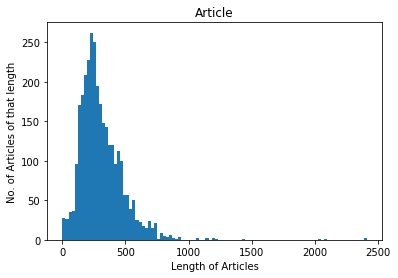

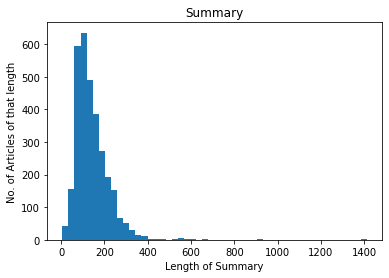

In [17]:
art_len=[len(i.split()) for i in X_train]
sum_len=[len(i.split()) for i in Y_train]
# print(art_len[0], sum_len[0])
plt.hist(art_len,bins=100)
plt.title('Article')
plt.xlabel("Length of Articles")
plt.ylabel("No. of Articles of that length")
plt.show()
plt.hist(sum_len,bins=50)
plt.title('Summary')
plt.xlabel("Length of Summary")
plt.ylabel("No. of Articles of that length")
plt.show()

In [18]:
X_train.head()

2252    strong demand triggers oil rallycrude oil pric...
3490    uk against government immigration rules racial...
897     watchdog probes deletionsthe information commi...
3698    coach ranieri sacked by valenciaclaudio ranier...
1485    qpr keeper day heads for prestonqueens park ra...
Name: Article with stop words, dtype: object

In [21]:
type(X_train)

pandas.core.series.Series

In [19]:
# X_train1 = X_train.values.tolist()
# X_train1

['strong demand triggers oil rallycrude oil prices surged back above the a barrel mark on thursday after an energy market watchdog raised its forecasts for global international energy agency warned demand for opec crude in the first quarter would outstrip the iea raised its estimate of oil demand growth by barrels a day to million barrels a us light crude rose to while brent crude in london gained to iea which advises industrialized nations on energy said the upward revision was due to stronger demand from china and other asian the fresh rally in crude prices followed gains on wednesday which were triggered by large falls in us crude supplies following a cold spell in north america in the us department of energy reported that crude stockpiles had fallen barrels to on top of ongoing problems for beleaguered russian oil giant yukos have also prompted the iea to revise its output estimates from russia a major i think that prices are now beginning to set a new range and it looks like the t

In [22]:
# type(X_train1)

list

In [20]:
# X_train1[0]

In [24]:
# import numpy as np
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import to_categorical

In [28]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train1)
# sequences = tokenizer.texts_to_sequences(X_train1)

In [29]:
sequences

[[390,
  523,
  13998,
  273,
  13999,
  273,
  349,
  5391,
  100,
  971,
  1,
  5,
  3495,
  422,
  10,
  959,
  49,
  32,
  805,
  163,
  1826,
  1150,
  41,
  2184,
  8,
  489,
  209,
  805,
  917,
  443,
  523,
  8,
  3720,
  1506,
  6,
  1,
  64,
  641,
  33,
  10420,
  1,
  8560,
  1150,
  41,
  3222,
  3,
  273,
  523,
  211,
  23,
  3401,
  5,
  350,
  2,
  159,
  3401,
  5,
  52,
  1030,
  1506,
  493,
  2,
  97,
  4557,
  1506,
  6,
  224,
  2022,
  2,
  8560,
  37,
  7941,
  14000,
  393,
  10,
  805,
  17,
  1,
  3223,
  10421,
  12,
  297,
  2,
  1961,
  523,
  26,
  424,
  4,
  68,
  1278,
  1,
  1453,
  3945,
  6,
  1506,
  349,
  886,
  2517,
  10,
  834,
  37,
  40,
  5151,
  23,
  542,
  2859,
  6,
  52,
  1506,
  3825,
  289,
  5,
  2573,
  3224,
  6,
  841,
  1048,
  6,
  1,
  52,
  814,
  3,
  805,
  628,
  9,
  1506,
  6359,
  34,
  1653,
  3401,
  2,
  10,
  145,
  3,
  2920,
  502,
  8,
  14001,
  550,
  273,
  520,
  642,
  16,
  42,
  1903,
  1,
  8560,
  2,


In [30]:
# type(sequences)

list

In [32]:
# sequences = np.array(sequences)
# sequences

C:\Users\Yash\AppData\Local\Temp/ipykernel_5744/551347806.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sequences = np.array(sequences)


array([list([390, 523, 13998, 273, 13999, 273, 349, 5391, 100, 971, 1, 5, 3495, 422, 10, 959, 49, 32, 805, 163, 1826, 1150, 41, 2184, 8, 489, 209, 805, 917, 443, 523, 8, 3720, 1506, 6, 1, 64, 641, 33, 10420, 1, 8560, 1150, 41, 3222, 3, 273, 523, 211, 23, 3401, 5, 350, 2, 159, 3401, 5, 52, 1030, 1506, 493, 2, 97, 4557, 1506, 6, 224, 2022, 2, 8560, 37, 7941, 14000, 393, 10, 805, 17, 1, 3223, 10421, 12, 297, 2, 1961, 523, 26, 424, 4, 68, 1278, 1, 1453, 3945, 6, 1506, 349, 886, 2517, 10, 834, 37, 40, 5151, 23, 542, 2859, 6, 52, 1506, 3825, 289, 5, 2573, 3224, 6, 841, 1048, 6, 1, 52, 814, 3, 805, 628, 9, 1506, 6359, 34, 1653, 3401, 2, 10, 145, 3, 2920, 502, 8, 14001, 550, 273, 520, 642, 16, 42, 1903, 1, 8560, 2, 12220, 41, 1423, 2466, 26, 937, 5, 331, 27, 123, 9, 349, 22, 72, 1312, 2, 112, 5, 44, 818, 4, 11, 815, 94, 1, 2, 17, 805, 793, 14002, 14003, 3, 3064]),
       list([85, 78, 71, 745, 599, 12221, 8561, 78, 5992, 1561, 1962, 65, 1, 1, 327, 1014, 16, 1616, 5, 120, 328, 232, 2, 296, 857,

In [33]:
# type(sequences)

numpy.ndarray

In [34]:
# sequences.dtype

dtype('O')

# LSTM BUILD MODEL

In [21]:
max_art_len=500
max_sum_len=100

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

In [24]:
art_vocab_size=len(article_tokenizer.word_index)+1

In [25]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [26]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 500) (1335, 500)


In [27]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

In [28]:
sum_vocab_size=len(summary_tokenizer.word_index)+1

In [29]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [30]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 100) (1335, 100)


In [31]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index

In [44]:
djfyjdhfgdsjdshf
model = Sequential()
model.add(Embedding(art_vocab_size, 50, input_length=max_art_length))
model.add(LSTM(100,return_sequences = True))
model.add(LSTM(100))
model.add(Dense(100,activation='relu'))
model.add(Dense(art_vocab_size,activation='softmax'))

In [45]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           1212800   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 100)          60400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 24256)             2449856   
Total params: 3,813,556
Trainable params: 3,813,556
Non-trainable params: 0
_________________________________________________________________


In [48]:
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy')

In [51]:
model.fit(padded_X_train,padded_Y_train,batch_size=256,epochs=100)
# model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
#           epochs=1,
#           validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
#           batch_size=64)

Epoch 1/100


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [256,24256] and labels shape [25600]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\Yash\AppData\Local\Temp/ipykernel_38208/710029309.py:1) ]] [Op:__inference_train_function_13769]

Function call stack:
train_function
